In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
import plotly
from greykite.framework.input.univariate_time_series import UnivariateTimeSeries

In [9]:
all_states = pd.read_csv(f'../data/all_states.csv')

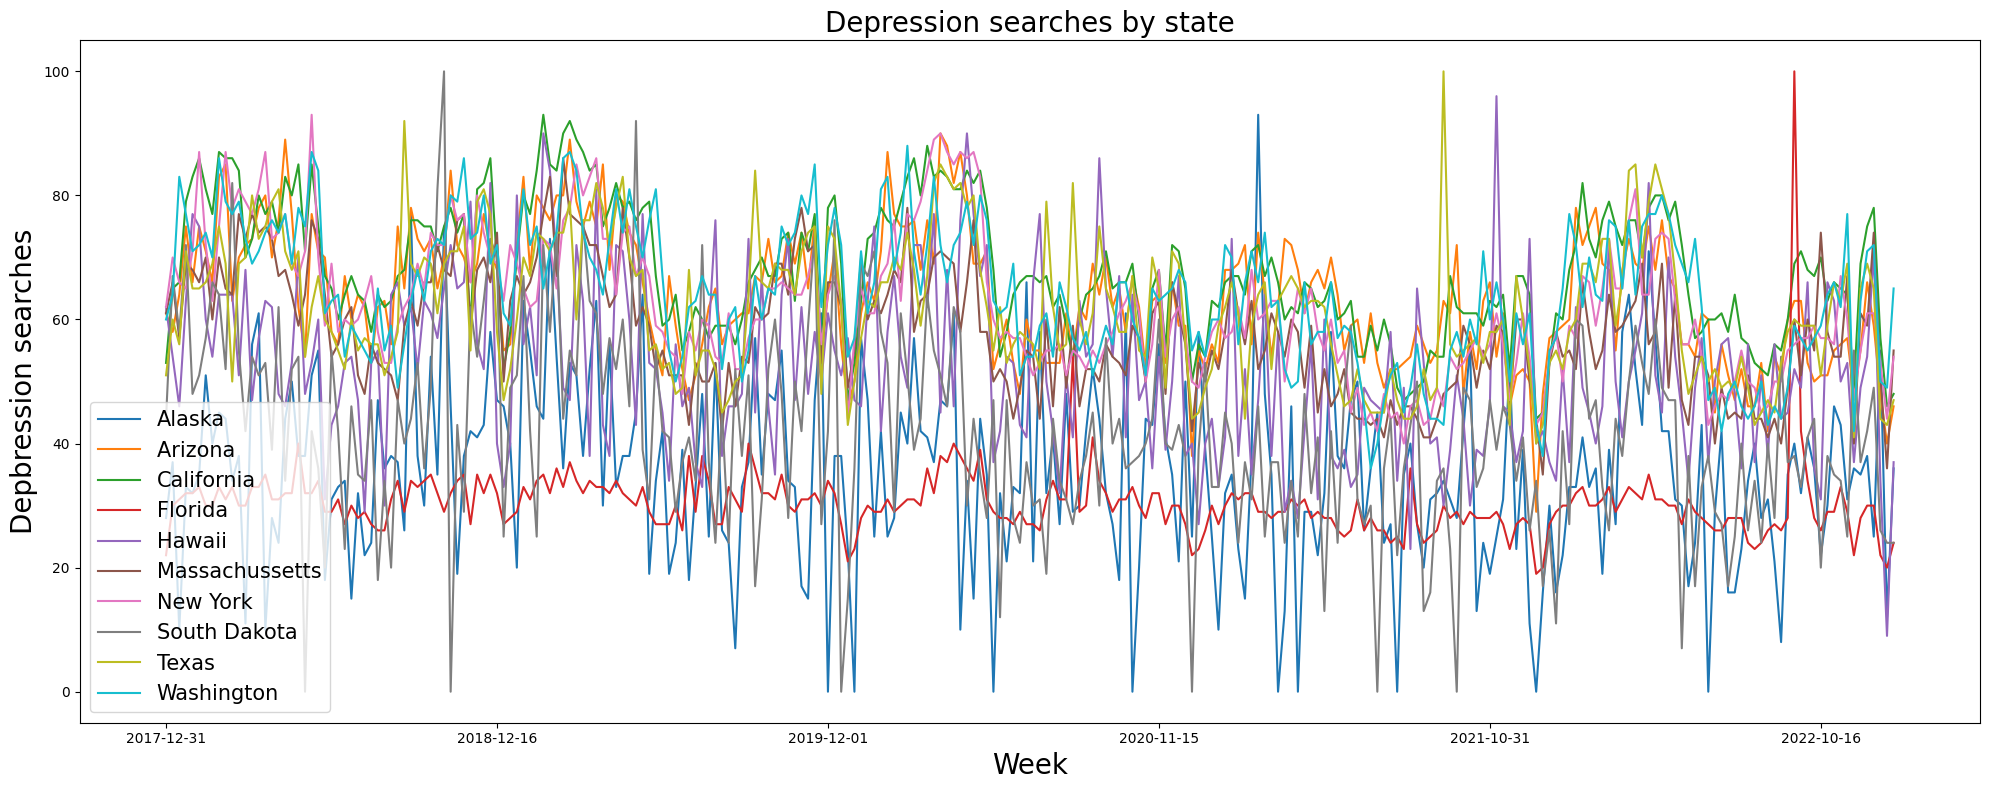

In [5]:
# Group by states and week

all_states.groupby(['week', 'state']).mean().unstack('state')['depression'].plot(figsize = (20, 8))
plt.xlabel('Week', size = 20)
plt.title('Depression searches by state', size = 20)
plt.ylabel('Depbression searches', size = 20)
plt.legend(fontsize = 15)
plt.tight_layout()
plt.savefig('../images/Depression by state and week.jpeg');

Two much information for one plot, It is hard to see what is goen on for each state. The states needs to be grouped. We are looking at the COVID19 restrictions and will group states by restrictions levels.

In [10]:
def plot_search_by_week_restriction(search):
    '''
    Input: Search term
    Output: Plot for this search term by week and COVID Restrictions severity
    '''
    search_str = search.title()
    if search == 'mental_health':
        search_str = 'Mental Health'
    all_states.groupby(['week', 'covid_restrictions']).mean().unstack('covid_restrictions')[search].plot(figsize = (20, 8))
    plt.xlabel('Week', size = 20)
    plt.title(f'{search_str} searches by COVID Restrictions severity', size = 20)
    plt.ylabel(f'{search_str} searches', size = 20)
    plt.legend(fontsize = 15)
    plt.tight_layout()
    plt.savefig(f'../images/{search_str} by covid_restrictions and week.jpeg');


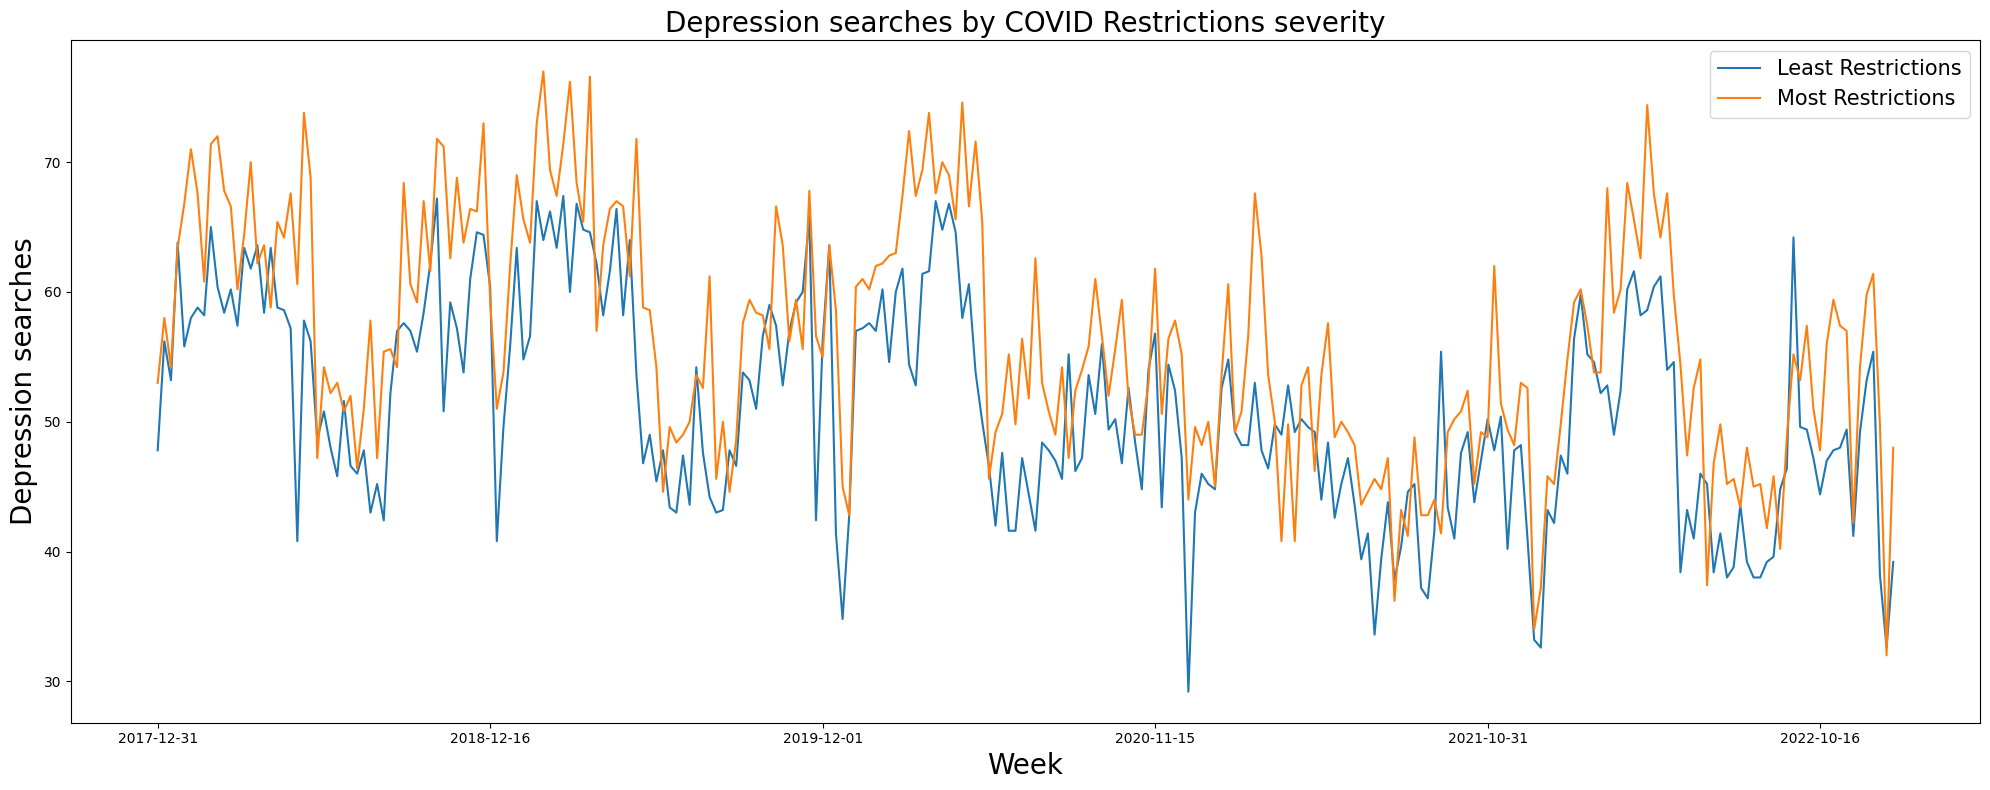

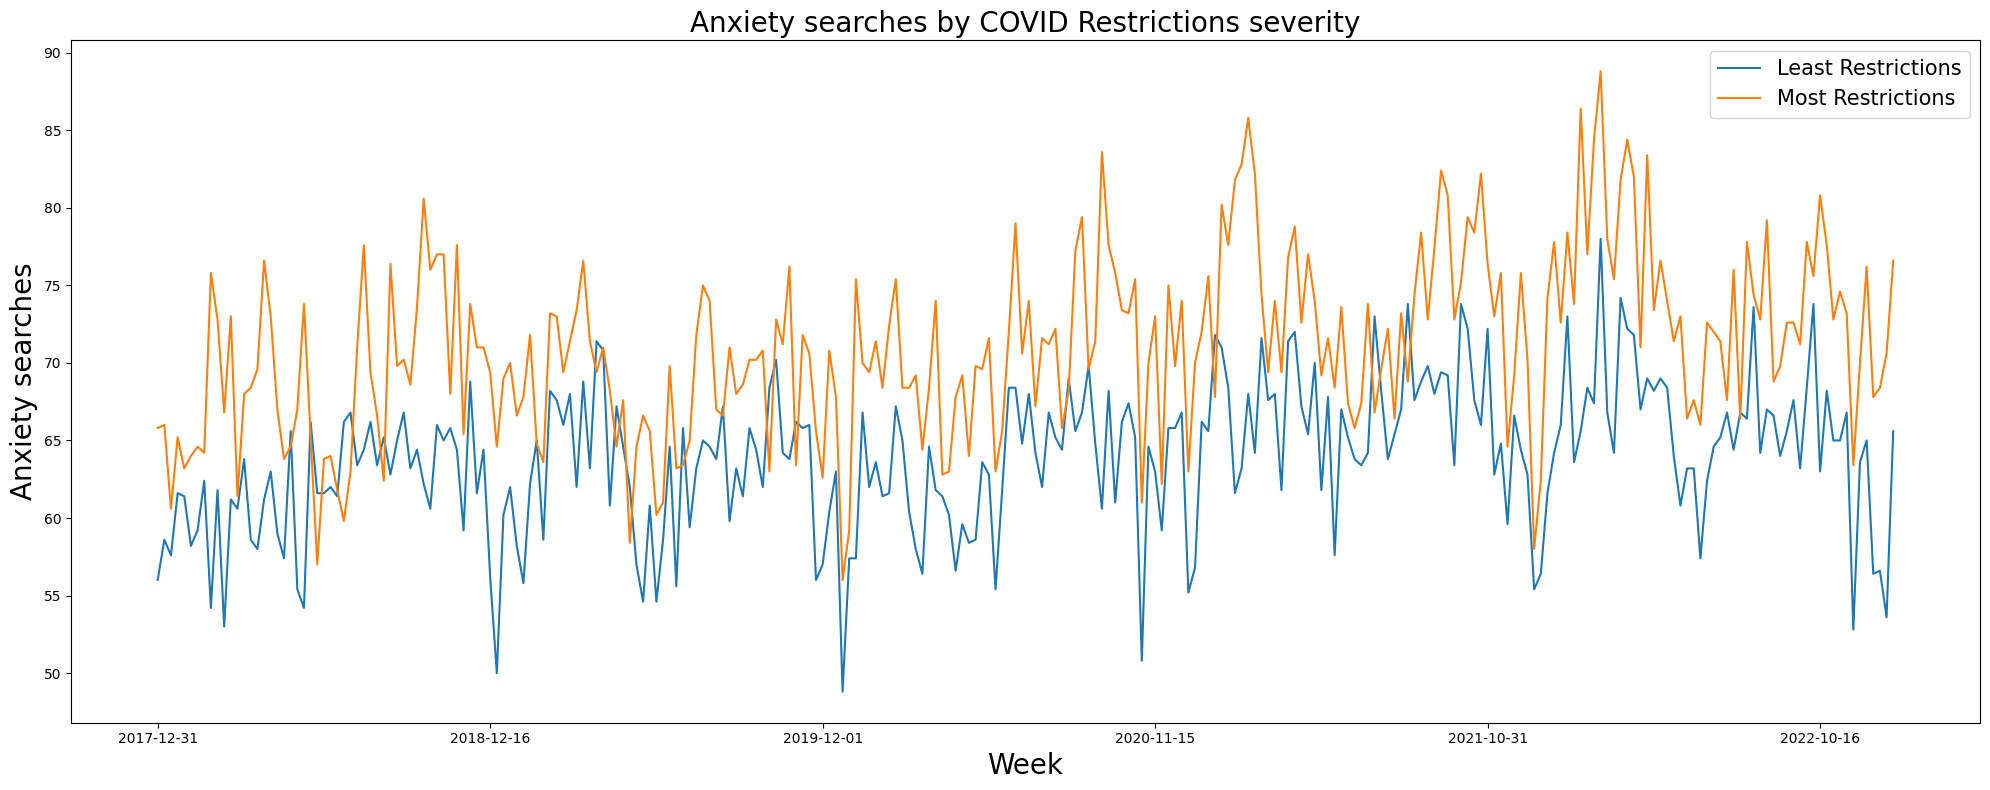

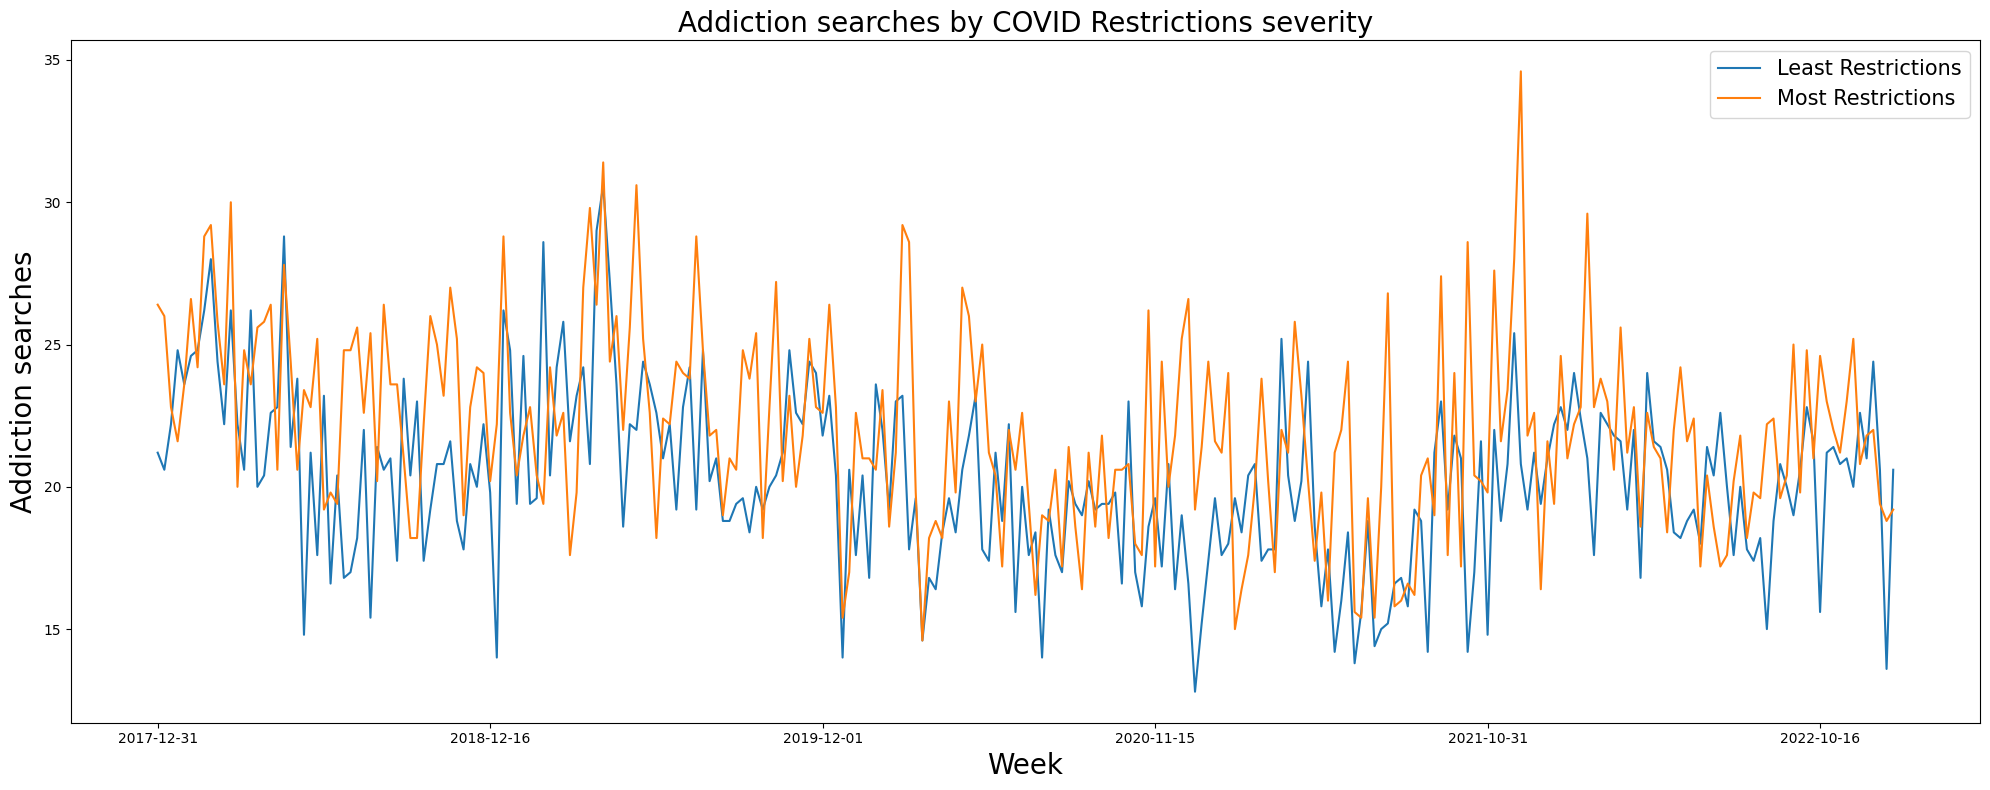

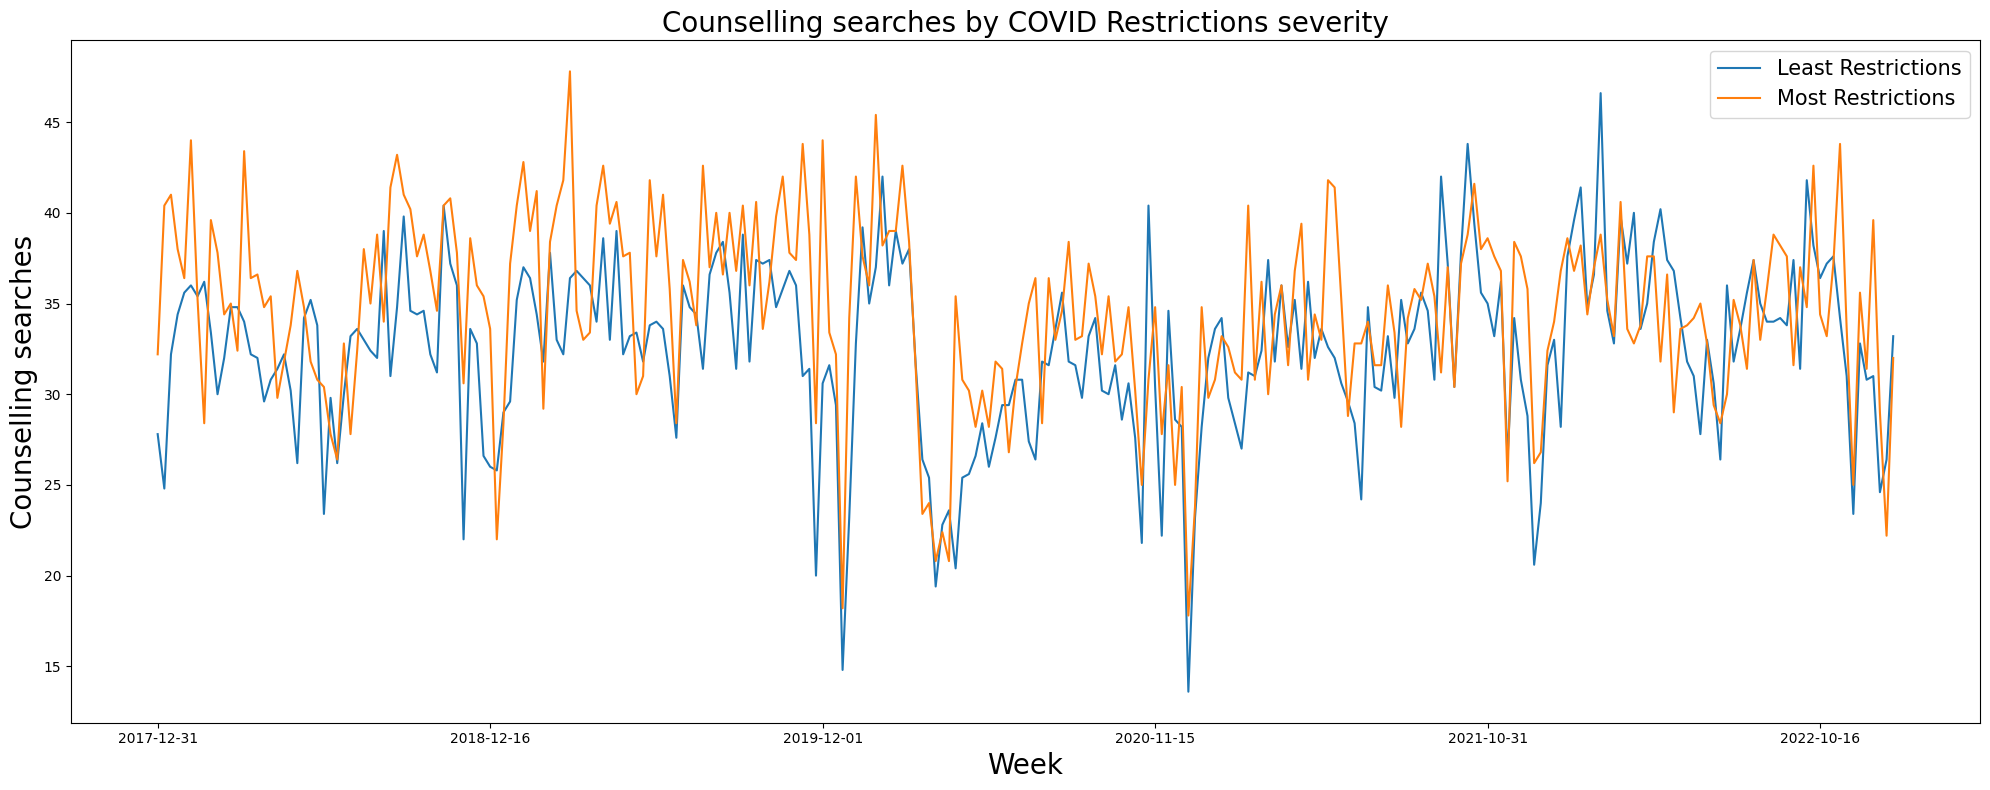

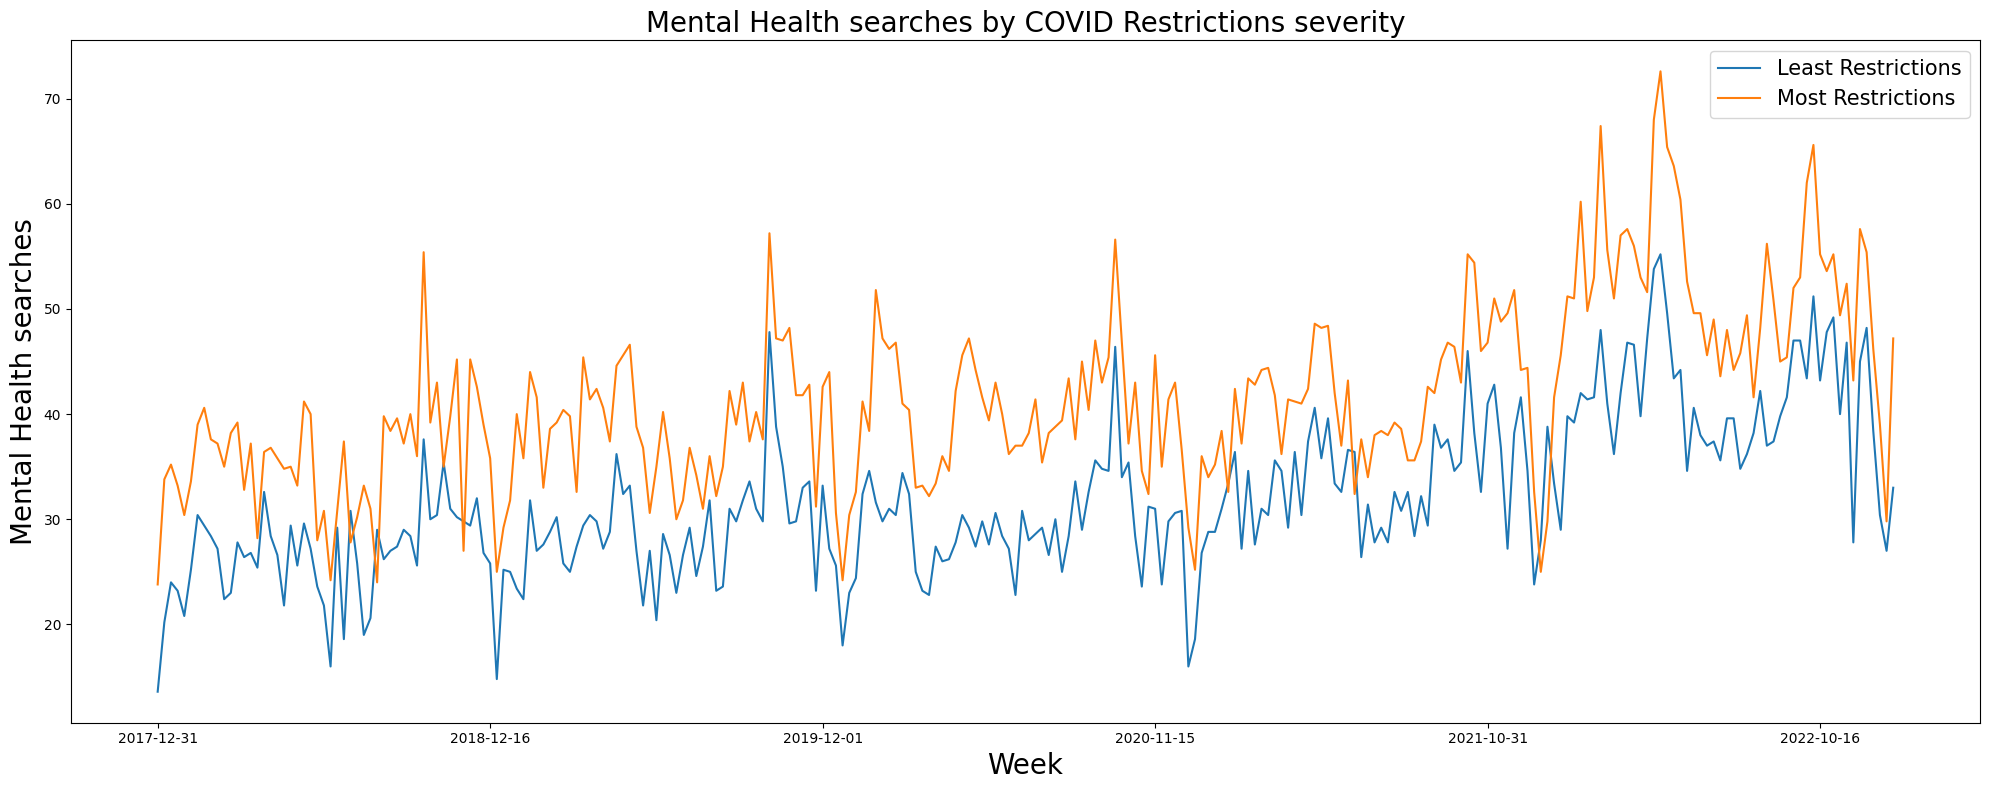

In [11]:
searches_list = ['depression', 'anxiety', 'addiction', 'counselling', 'mental_health']

for search in searches_list:
    plot_search_by_week_restriction(search)

This groups provide better visuals and even for Mental Health search there is a noticible devision in searxches in the middle of 2020

In [3]:
most_restricted = pd.read_csv(f'../data/most_restricted.csv')
least_restricted = pd.read_csv(f'../data/least_restricted.csv')

For many time series models the data should be stationary.

In [11]:
# Check for Stationarity adapted from https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [12]:
# Check Most Restricted for stationarity
for name, column in most_restricted[['depression', 'anxiety', 'addiction', 'counselling', 'mental_health']].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "depression" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.5433
 No. Lags Chosen       = 5
 Critical value 1%     = -3.456
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.0069. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "anxiety" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.2912
 No. Lags Chosen       = 3
 Critical value 1%     = -3.456
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.0005. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "addiction" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significa

In [13]:
# Check Least Restricted for stationarity
for name, column in least_restricted[['depression', 'anxiety', 'addiction', 'counselling', 'mental_health']].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "depression" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.9168
 No. Lags Chosen       = 2
 Critical value 1%     = -3.456
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.0019. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "anxiety" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.8707
 No. Lags Chosen       = 4
 Critical value 1%     = -3.456
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.0023. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "addiction" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significa

## Check Seasonality and statistics of the different searches 

In [17]:
def data_seasonality_stats(data, search):
    '''
    Plots to check for seasonality of data and descriptions of the columns
    Inputs:
    data - dataframe 
    search - search term
    
    Outputs:
    Description of search column 
    Monthly seasonality plot by year
    Weekly seasonality plot by year
    '''
    search_str = search.title()
    if search == 'mental_health':
        search_str = 'Mental Health'
   
    # Make timeseries data
    ts = UnivariateTimeSeries()
    ts.load_data(
    df=data[['week', search]],
    time_col='week',
    value_col=search,
    freq='W-SUN')
    
    # Print Search stats
    
    print(f'Description of the {search_str} column')
    print(ts.describe_value_col())
    
    fig = ts.plot_quantiles_and_overlays(
    groupby_time_feature='month',
    show_mean=True,
    show_quantiles=False,
    show_overlays=True,
    center_values=True,
    overlay_label_time_feature='year',  
    overlay_style={'line': {'width': 1}, "opacity": 0.5},
    xlabel='Month',
    ylabel=ts.original_value_col,
    title=f'{search_str} Monthly seasonality by year (centered)')
    fig.show("svg")
        
    fig = ts.plot_quantiles_and_overlays(
    groupby_time_feature='woy',
    show_mean=True,
    show_quantiles=False,
    show_overlays=True,
    center_values=True,
    overlay_label_time_feature='year',  
    overlay_style={'line': {'width': 1}, 'opacity': 0.5},
    xlabel='Week of year',
    ylabel=ts.original_value_col,
    title=f'{search_str} Weekly seasonality by year (centered)')
    fig.show("svg")
        

### Most Restricted States

Description of the Depression column
count    262.000000
mean      56.357252
std        9.168144
min       32.000000
25%       49.250000
50%       55.600000
75%       63.550000
max       77.000000
Name: y, dtype: float64


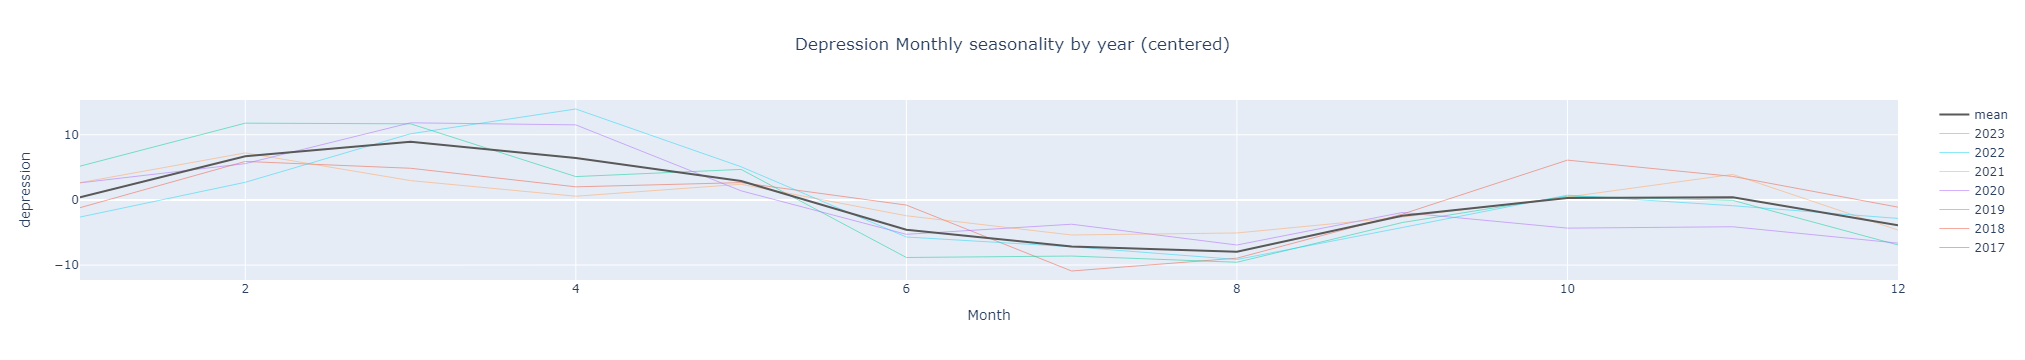

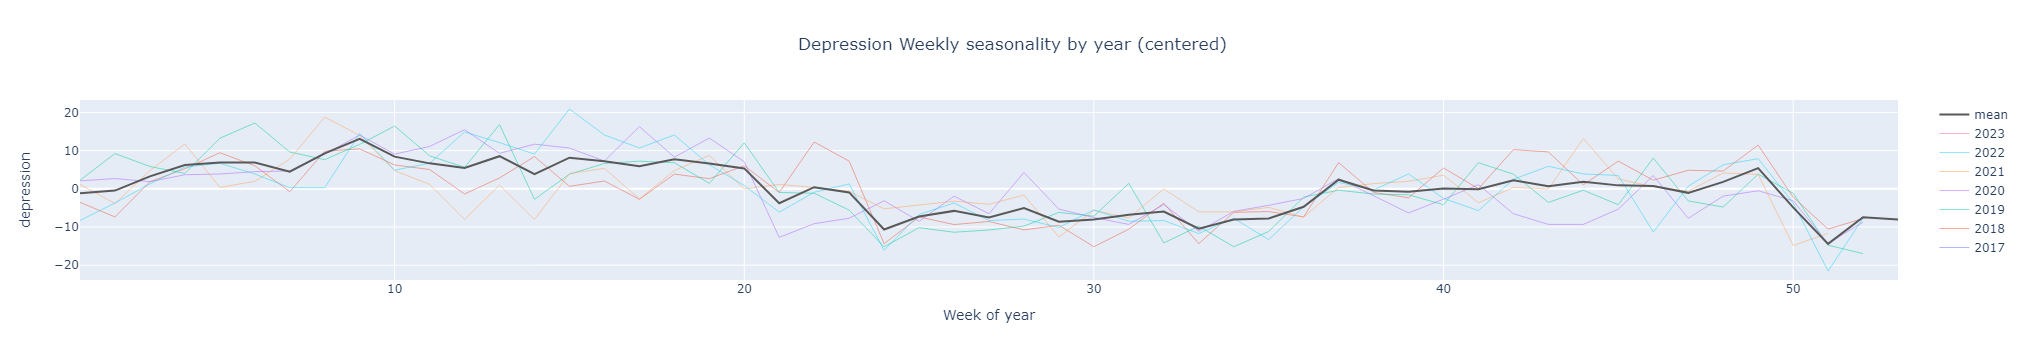

Description of the Anxiety column
count    262.000000
mean      71.045802
std        5.810840
min       56.000000
25%       67.050000
50%       71.000000
75%       74.550000
max       88.800000
Name: y, dtype: float64


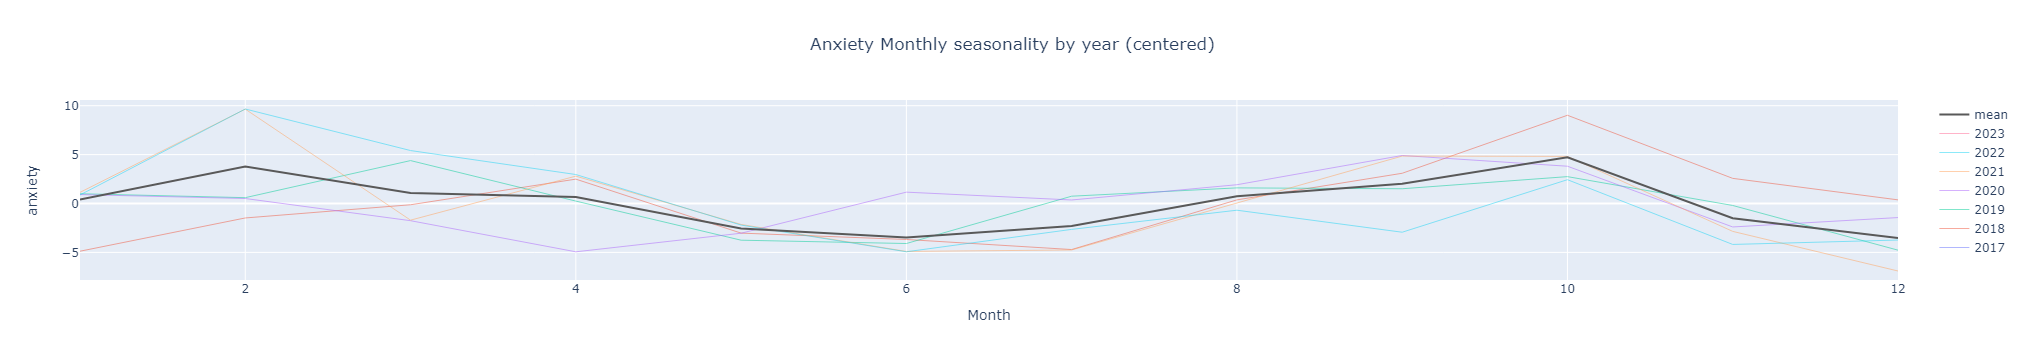

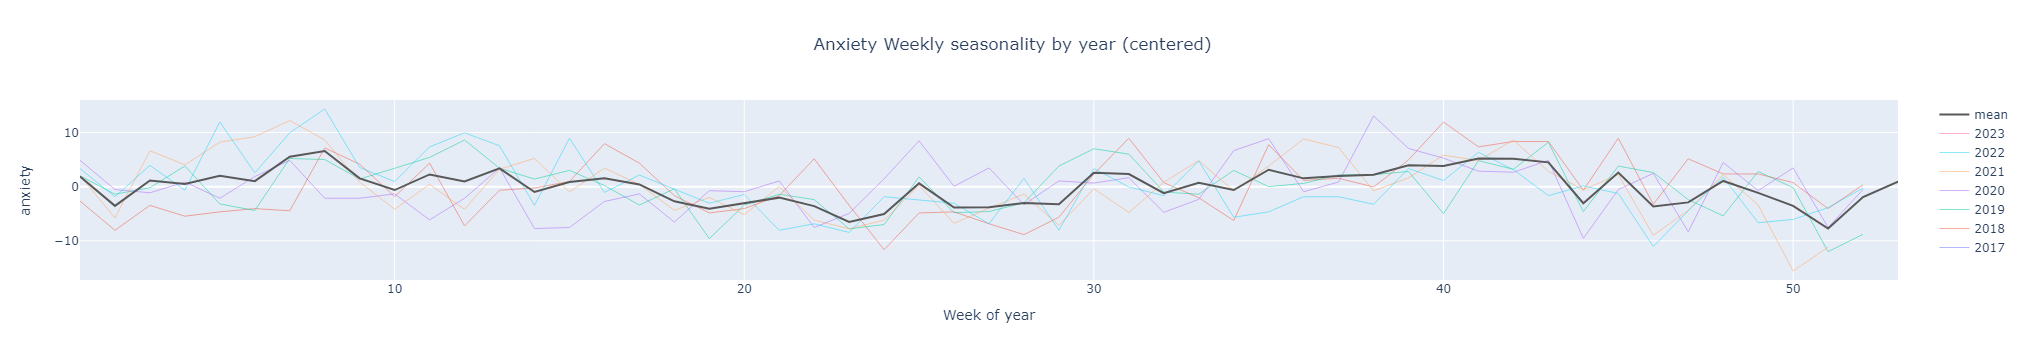

Description of the Addiction column
count    262.000000
mean      22.035115
std        3.423335
min       14.600000
25%       19.800000
50%       21.800000
75%       24.350000
max       34.600000
Name: y, dtype: float64


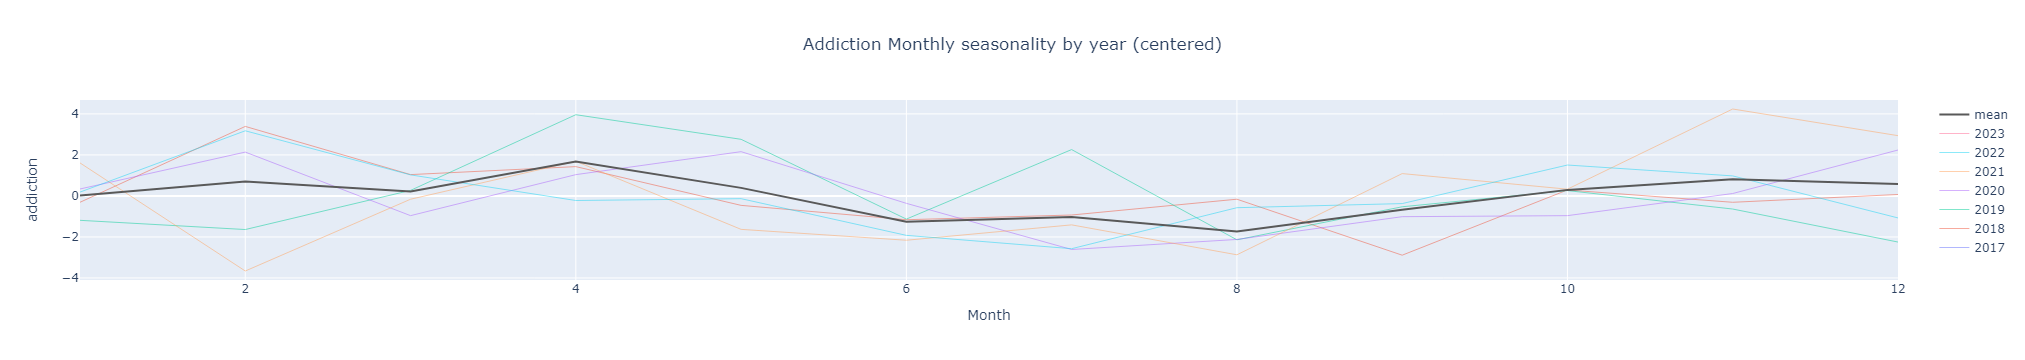

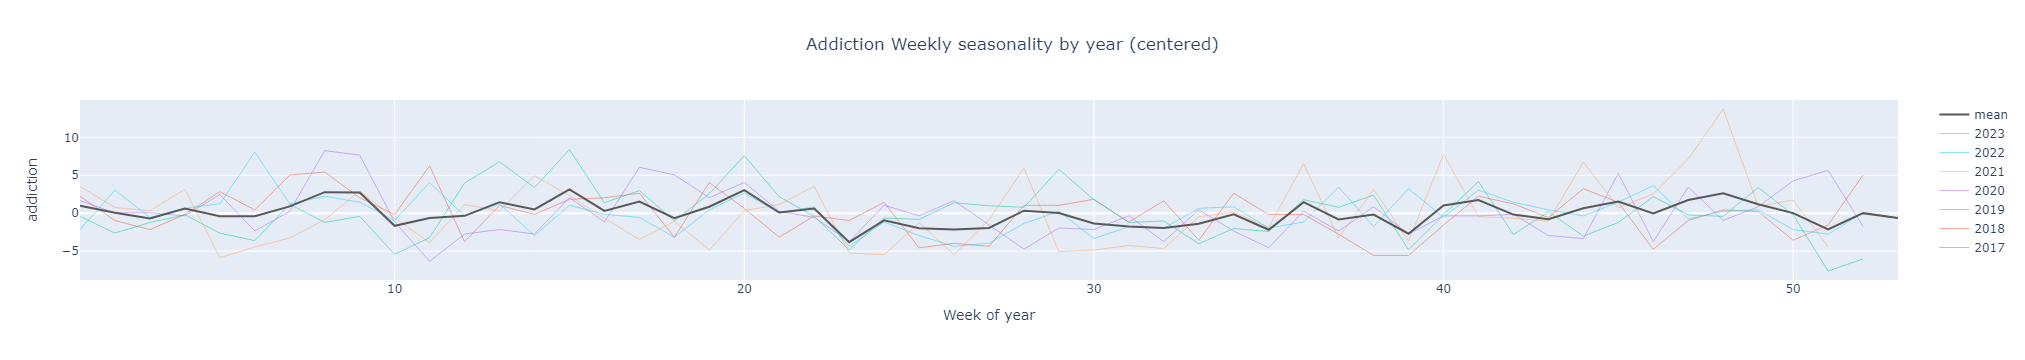

Description of the Counselling column
count    262.000000
mean      34.670229
std        5.009289
min       17.800000
25%       31.600000
50%       35.000000
75%       37.950000
max       47.800000
Name: y, dtype: float64


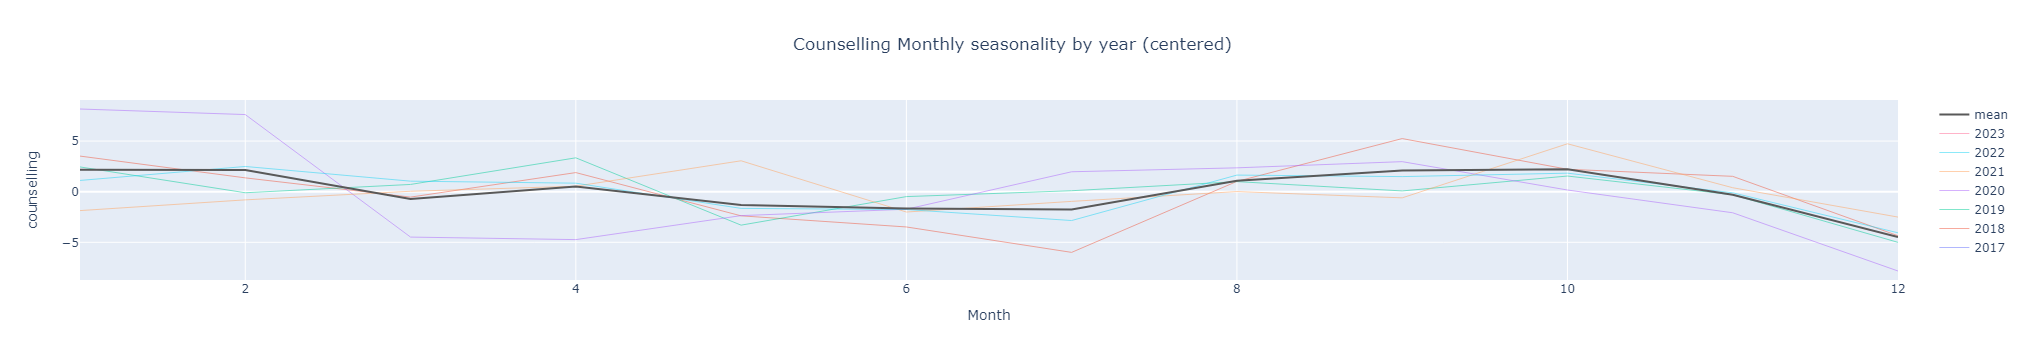

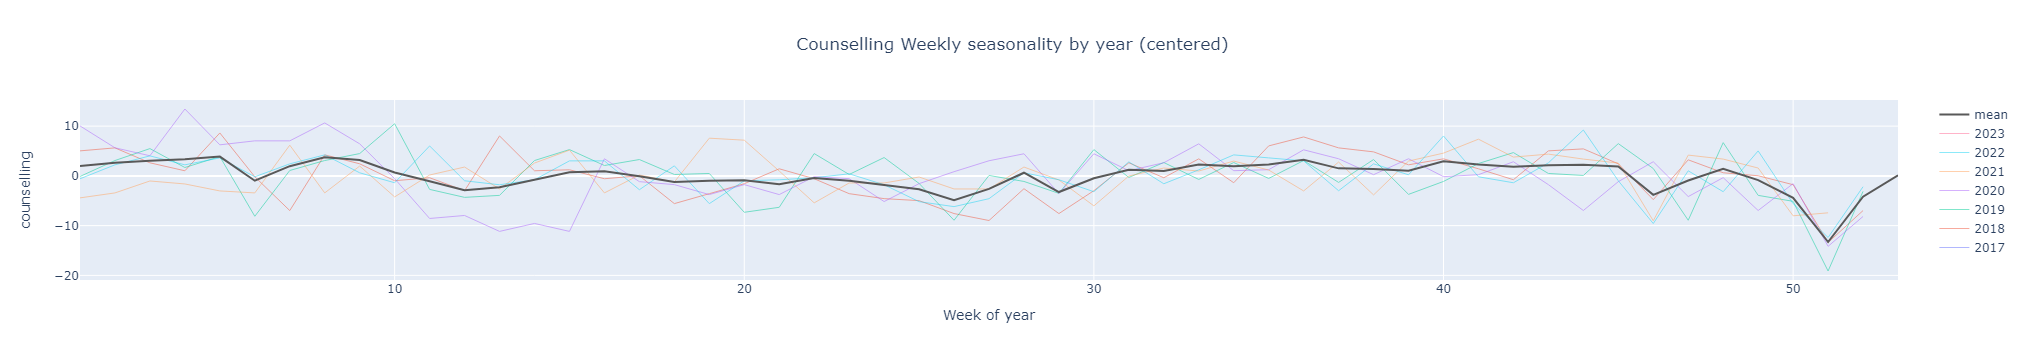

Description of the Mental Health column
count    262.000000
mean      41.519084
std        8.557322
min       23.800000
25%       35.800000
50%       40.600000
75%       46.150000
max       72.600000
Name: y, dtype: float64


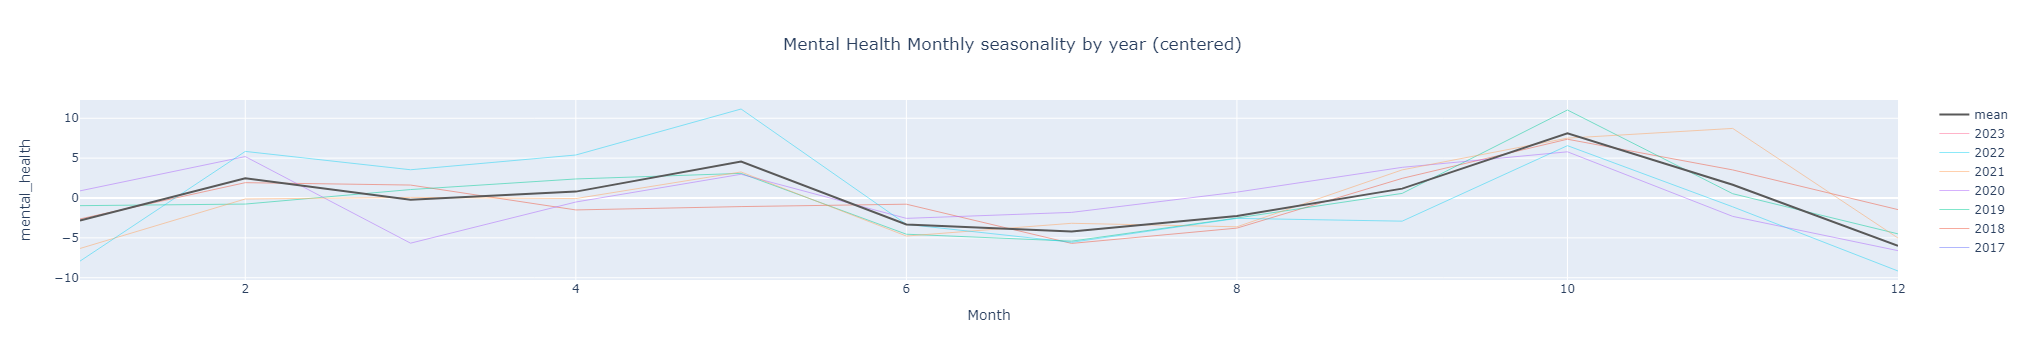

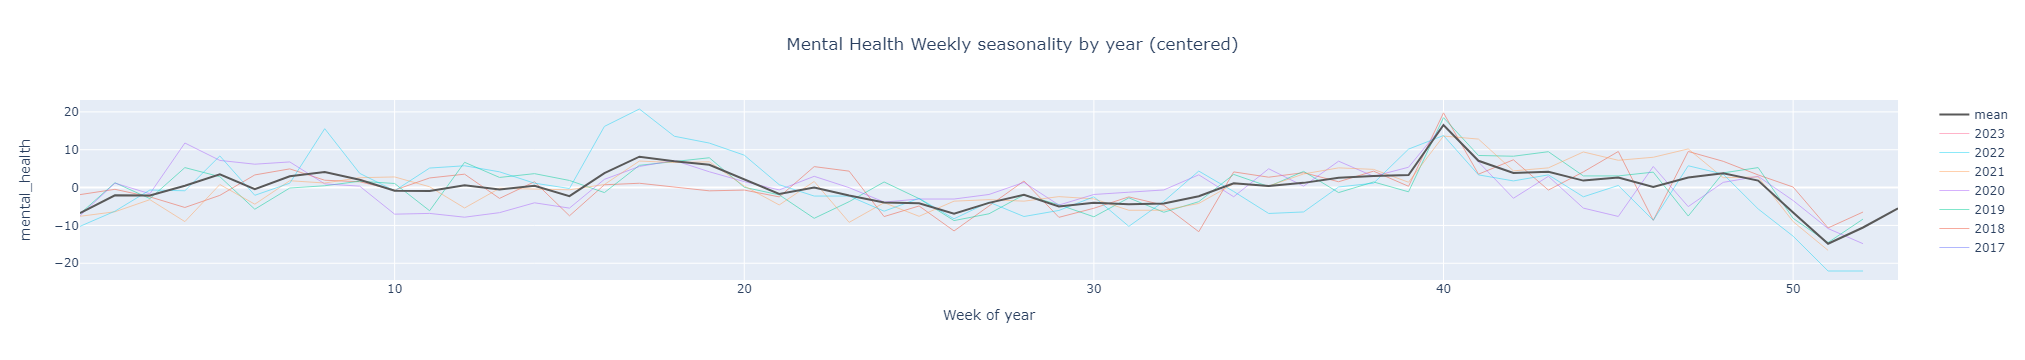

In [18]:
for search in searches_list:
    data_seasonality_stats(most_restricted, search)

### Least Restricted States

Description of the Depression column
count    262.000000
mean      51.040458
std        8.257116
min       29.200000
25%       44.900000
50%       49.700000
75%       57.550000
max       67.400000
Name: y, dtype: float64


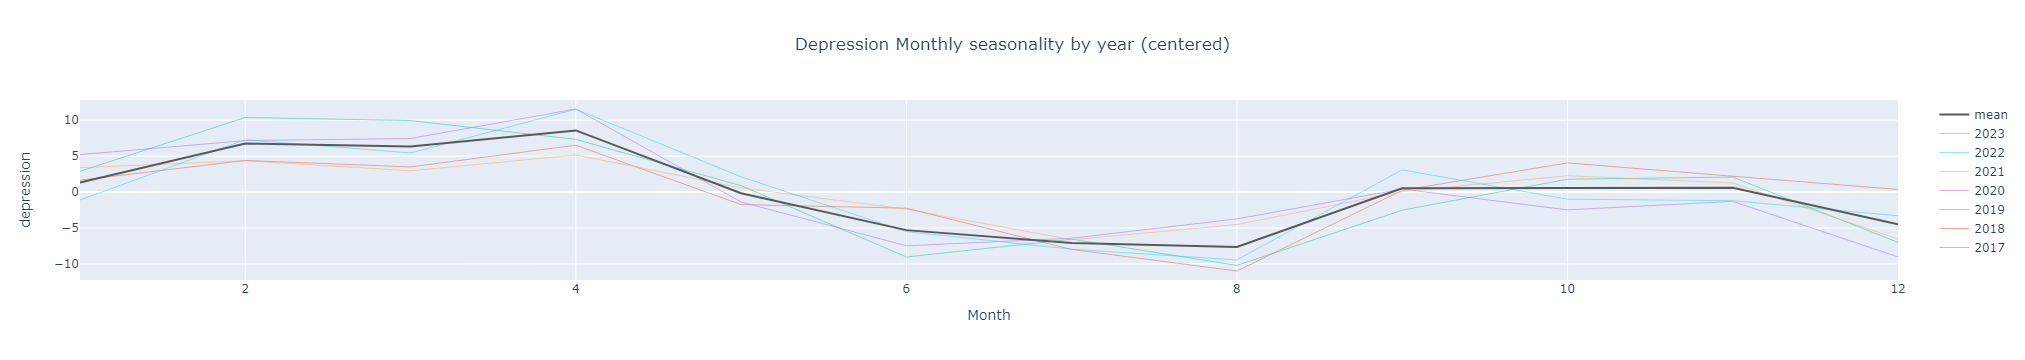

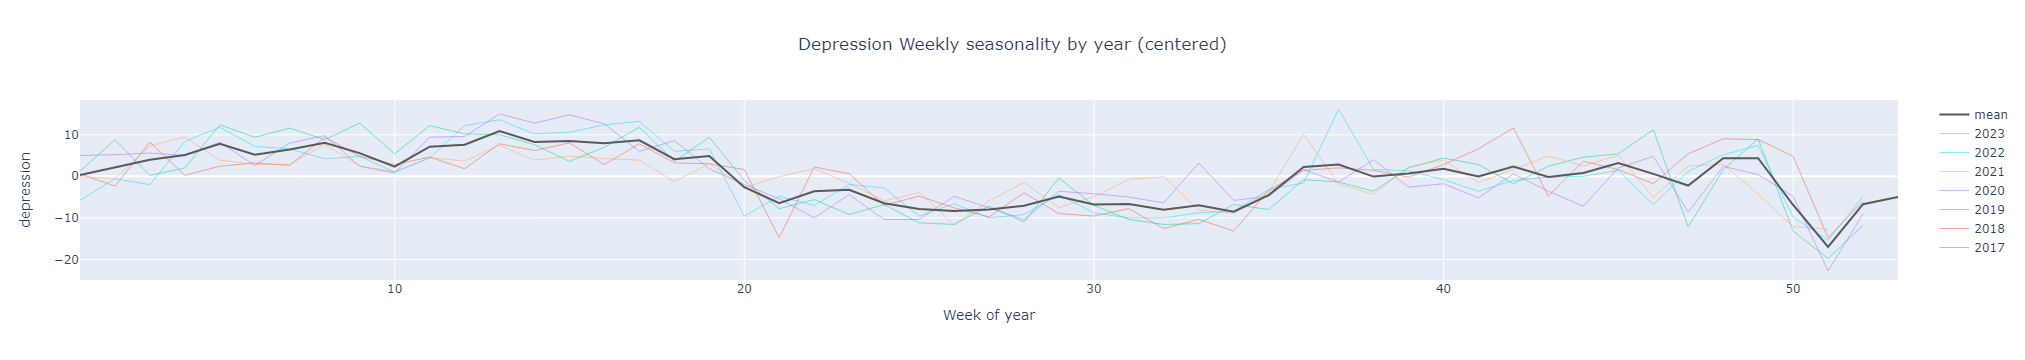

Description of the Anxiety column
count    262.000000
mean      63.834351
std        4.772162
min       48.800000
25%       61.400000
50%       64.400000
75%       66.800000
max       78.000000
Name: y, dtype: float64


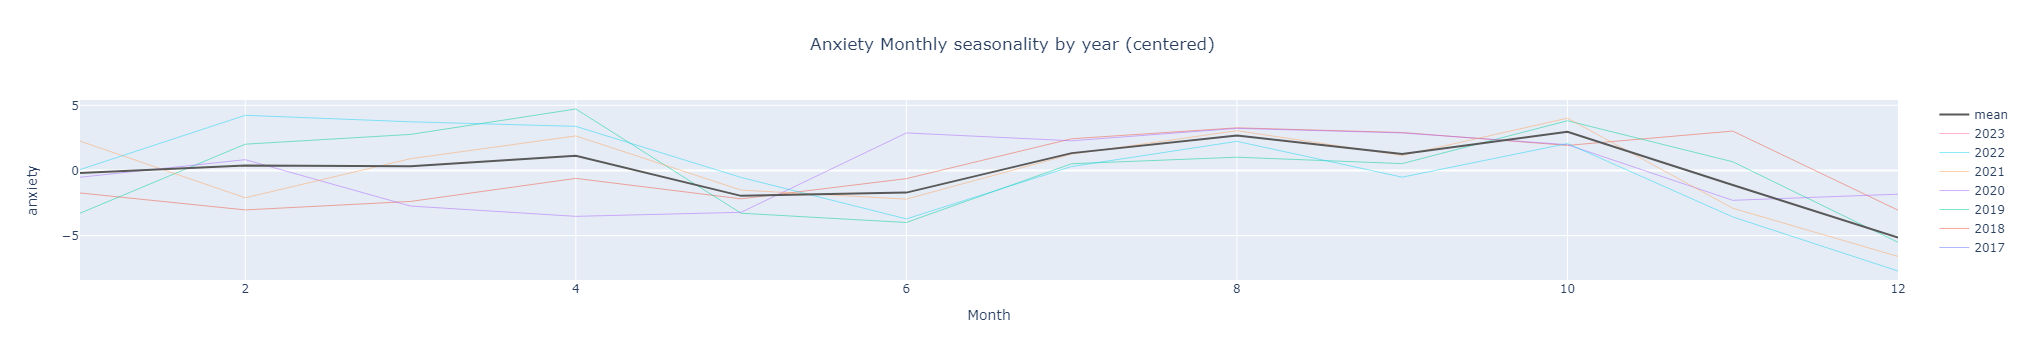

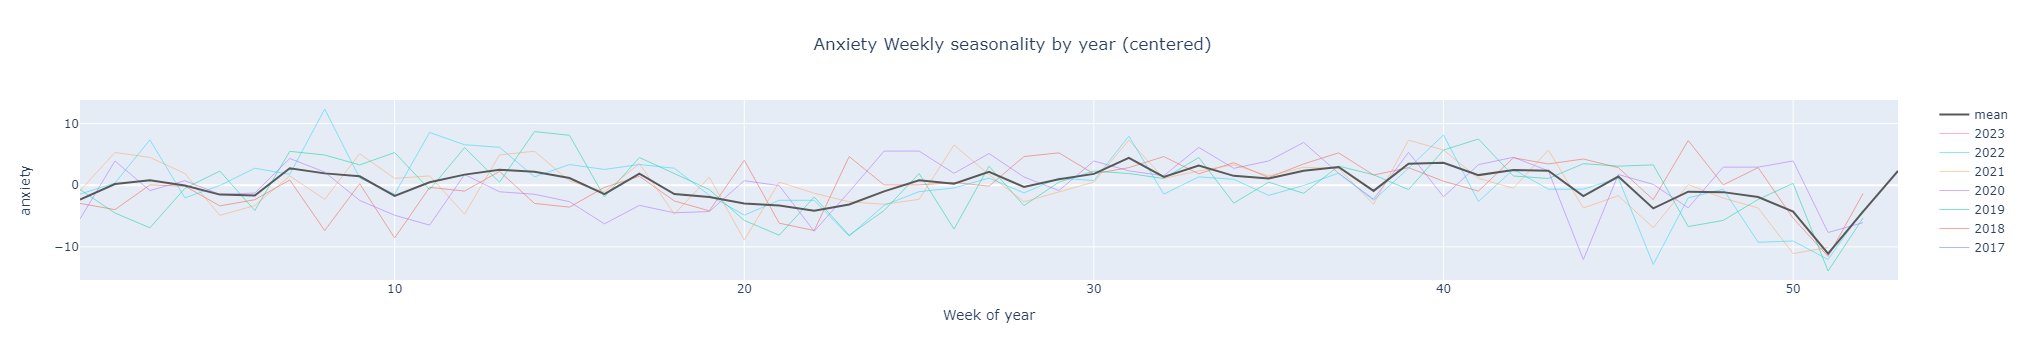

Description of the Addiction column
count    262.000000
mean      20.221374
std        3.084680
min       12.800000
25%       18.250000
50%       20.400000
75%       22.200000
max       30.600000
Name: y, dtype: float64


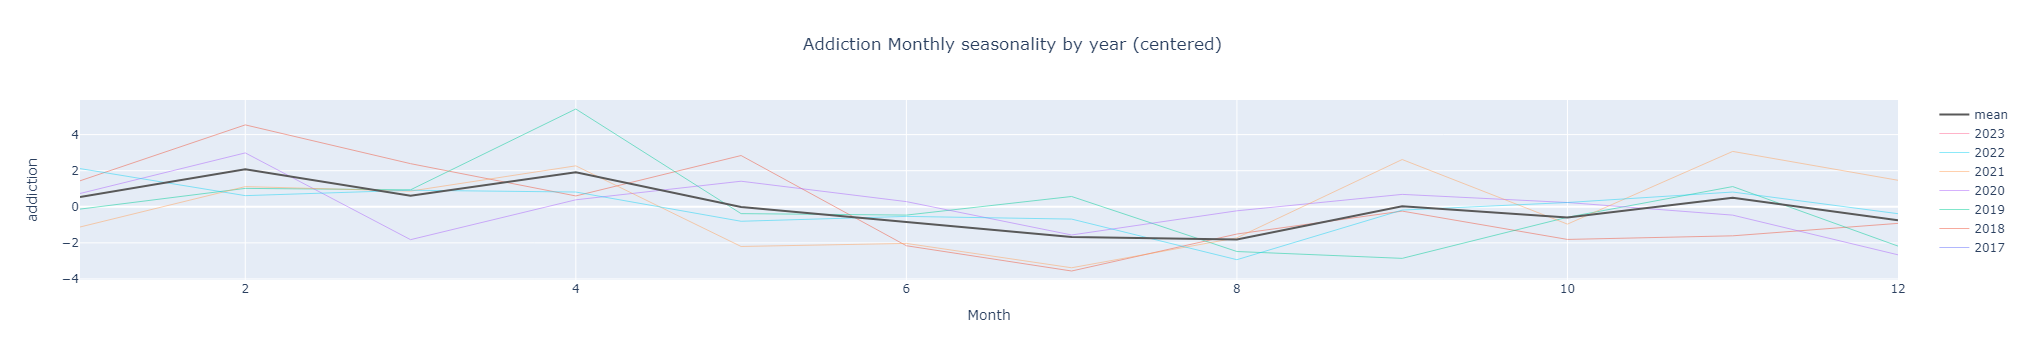

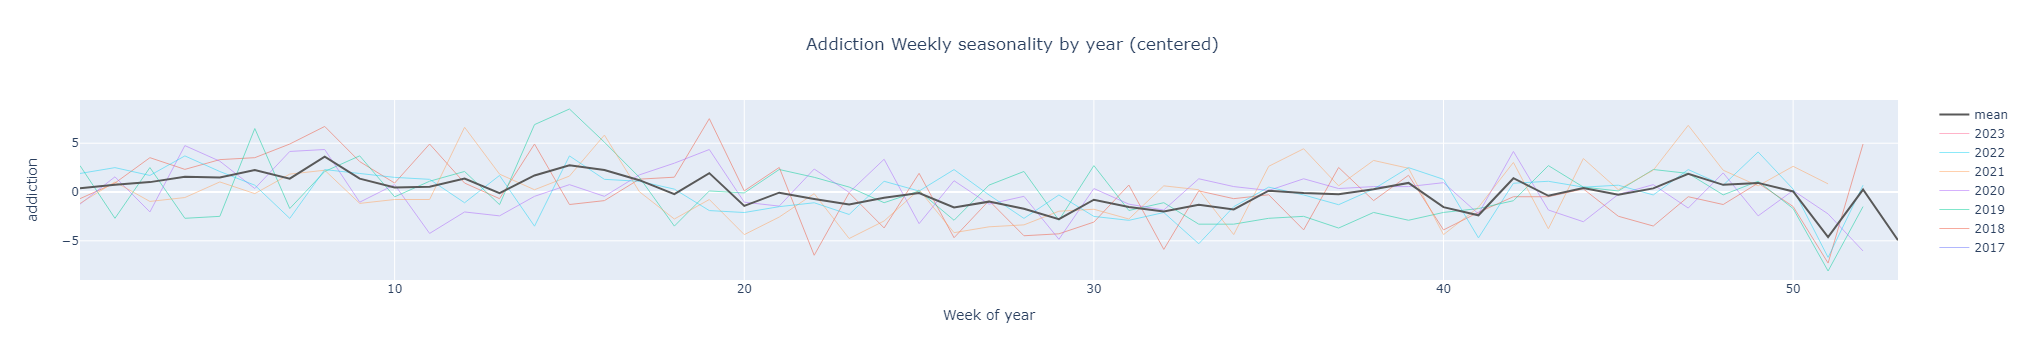

Description of the Counselling column
count    262.000000
mean      32.486260
std        4.810147
min       13.600000
25%       30.200000
50%       33.000000
75%       35.600000
max       46.600000
Name: y, dtype: float64


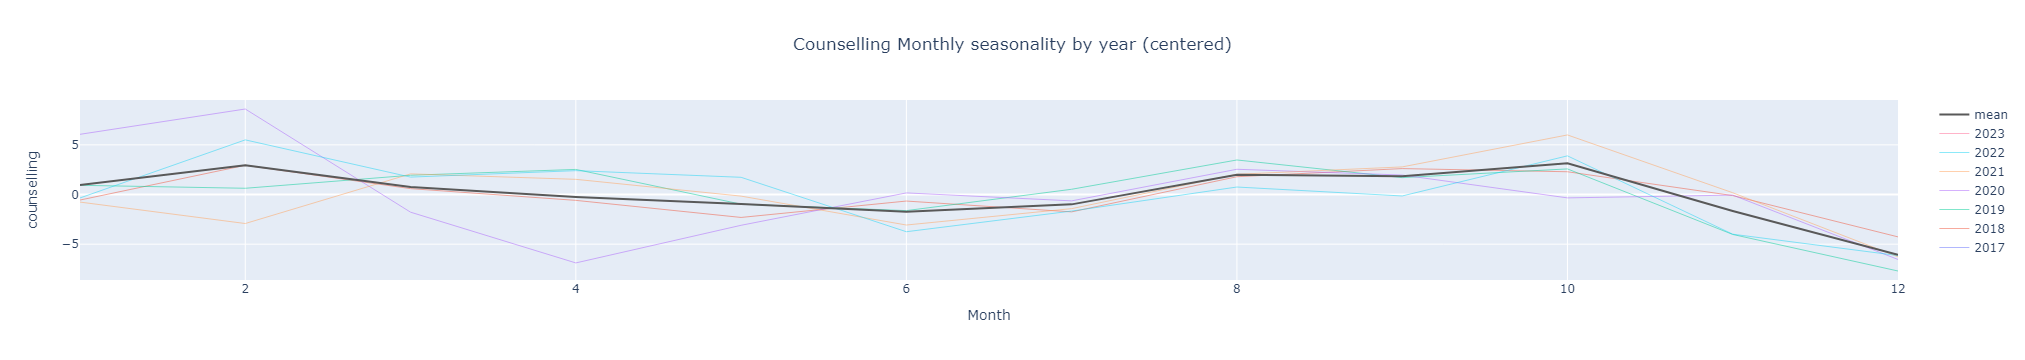

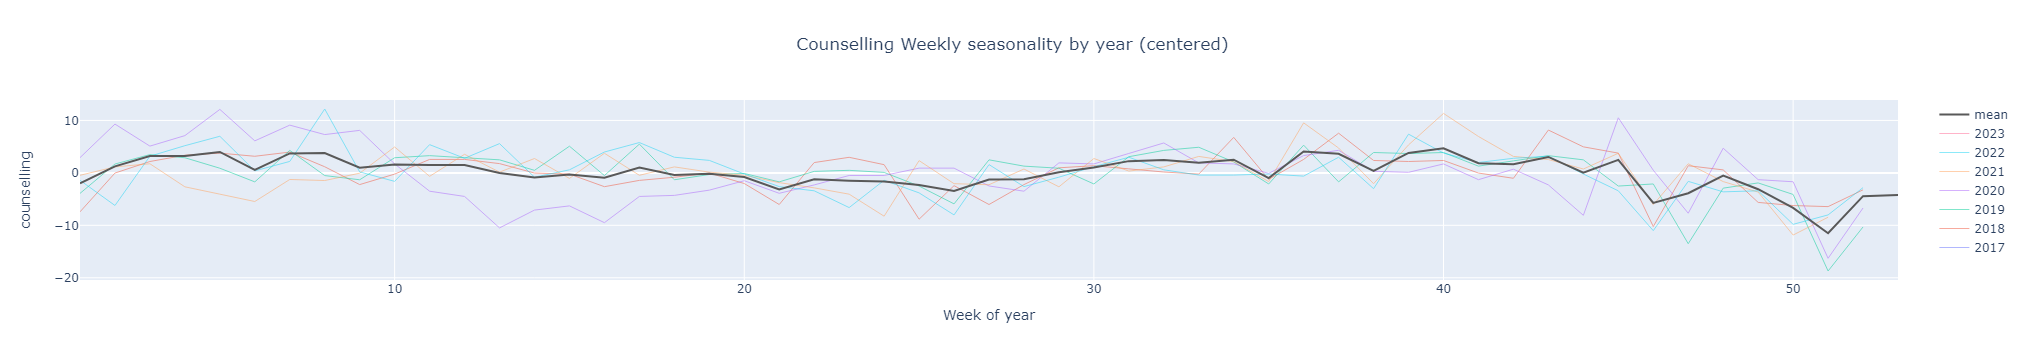

Description of the Mental Health column
count    262.000000
mean      31.716794
std        7.320633
min       13.600000
25%       27.200000
50%       30.400000
75%       36.100000
max       55.200000
Name: y, dtype: float64


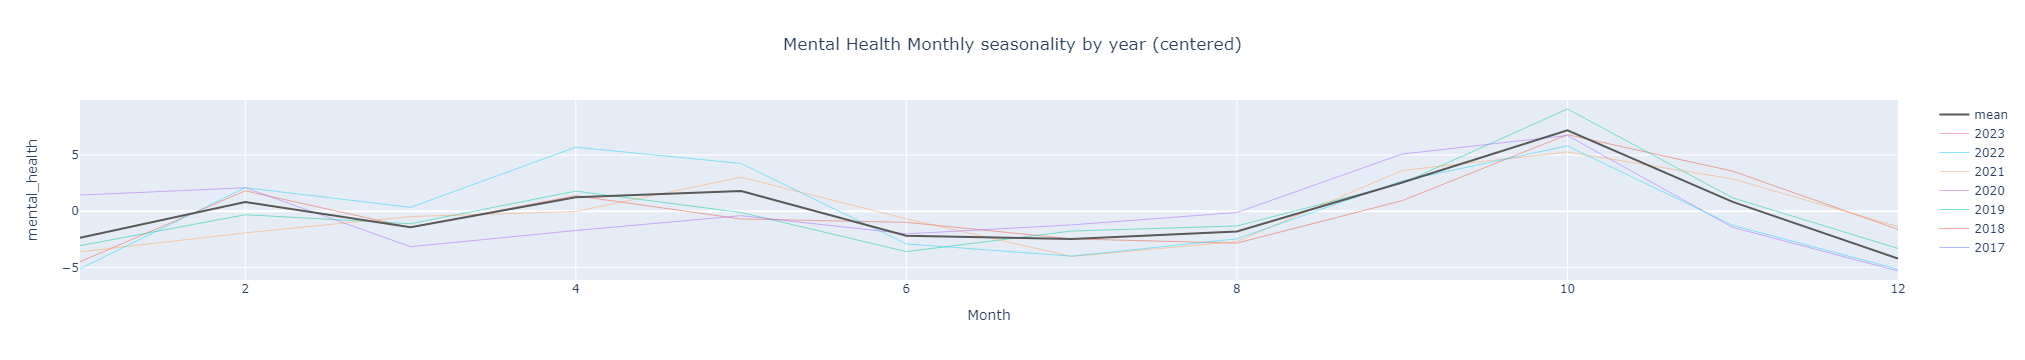

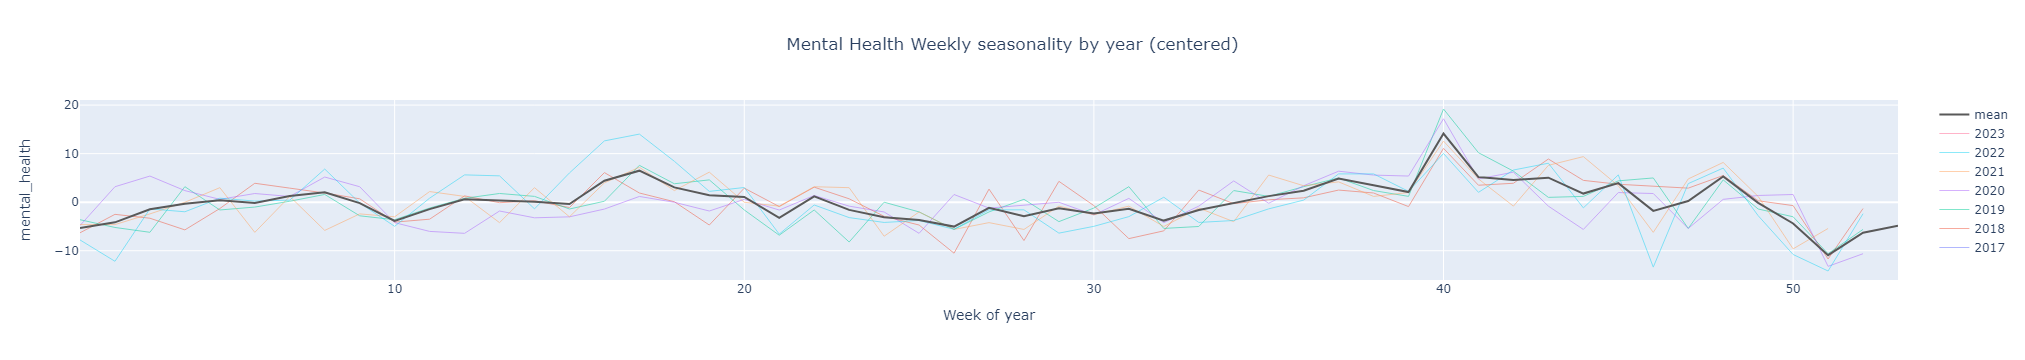

In [20]:
for search in searches_list:
    data_seasonality_stats(least_restricted, search)